<div style="
    border: 2px solid #333;
    background: #f9f9f9;
    padding: 16px 24px;
    margin: 20px 0;
    border-radius: 8px;
    font-family: sans-serif;
    overflow: hidden;
">
<div style="float: right; font-size: 12px; color: #555; text-align: right;">
    Vince Mbanze<br>
    July 16, 2025
</div>
<h1 style="margin:0; color:#333; text-align:center; border-bottom: 2px solid #ccc; padding-bottom: 12px;">🧪 Quantum Chemistry Energy Prediction on the ANI-1 Dataset 🧪</h1>
<p style="margin:16px 0 0 0;">
    This notebook details the process of training a Graph Neural Network (GNN) to predict the quantum chemical energies of molecular conformers from the ANI-1 dataset. The dataset is distributed across multiple HDF5 files ("shards").
    <br><br>
    We leverage <b>PyTorch Geometric</b> to build and train a <b>SchNet</b> model, a GNN architecture designed for modeling chemical systems. The core task is to predict the total energy of a given 3D conformer. To improve training stability and performance, the model is trained to predict the <b>residual energy</b>—the difference between the true DFT energy and a calculated baseline energy derived from atomic contributions. The final model's performance is evaluated against the test set, achieving chemical accuracy.
</p>
</div>

In [37]:
# Core ML & Data Libraries
import scanpy as sc
import torch
import numpy as np
import pandas as pd
import h5py
import glob
from sklearn.linear_model import LinearRegression

# PyTorch Geometric Components
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import SchNet

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The '__version__' attribute is deprecated")
plt.rcParams.update({'figure.dpi': 80, 'figure.facecolor': 'white'})

# Set plotting aesthetics using matplotlib directly to bypass the bug
plt.rcParams.update({'figure.dpi': 80, 'figure.facecolor': 'white'})

# The rest of the cell is fine
sc.logging.print_header()

Package,Version
pandas,2.3.1
torch,2.2.2
numpy,1.26.4
h5py,3.14.0
tqdm,4.67.1
scikit-learn,1.7.0
torch-geometric,2.6.1
matplotlib,3.10.0
seaborn,0.13.2
scanpy,1.11.2


<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">⚙️ 1. Setup and Configuration</h3>
  <p style="margin:12px 0 0 0;">
    This cell handles the initial setup. It imports necessary libraries such as <b>PyTorch</b>, <b>PyTorch Geometric</b>, and <b>h5py</b>. A configuration dictionary `CONFIG` is defined to manage hyperparameters and data paths. It also sets up the computational device (CUDA or CPU) and a mapping from atomic symbols (H, C, N, O) to their atomic numbers (Z), which is essential for the model.
  </p>
</div>

In [40]:
import seaborn as sns
import torch
import numpy as np
import glob
import h5py
from tqdm.notebook import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data
from torch_geometric.nn import SchNet

sns.set_theme(style="whitegrid")

# Configuration dictionary
CONFIG = {
    "data_path": "C:/Users/vince/ANI-1_release/ani_gdb_s0?.h5",
    "max_graphs": 10000,
    "train_split": 0.8,
    "batch_size": 64,
    "hidden_channels": 128,
    "num_filters": 128,
    "num_interactions": 6,
    "num_gaussians": 50,
    "cutoff": 5.0,
    "lr": 1e-4,
    "epochs": 20,
}

# Set up device and atomic number mapping
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
symbol_to_Z = {"H": 1, "C": 6, "N": 7, "O": 8}
print(f"Using device: {device}")

Using device: cuda


<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🔬 2. Data Exploration: Inspecting the HDF5 Shards</h3>
  <p style="margin:12px 0 0 0;">
    Before processing the data, this cell performs a quick exploration of the HDF5 file structure. It uses `glob` to find all data shards and `h5py` to open the first one. It then recursively lists the groups and datasets within the file, printing their names, shapes, and data types. This inspection reveals that each shard contains groups of molecules, and each molecule group contains datasets for atomic species, 3D coordinates for multiple conformers, and their corresponding energies.
  </p>
</div>

In [42]:
import glob
import h5py

# 1) Locate the shards
shard_paths = glob.glob(CONFIG["data_path"])
print(f"Found {len(shard_paths)} shards.\n")

# 2) Scan each file
for shard in shard_paths:
    with h5py.File(shard, 'r') as f:
        top_group = list(f.keys())[0]
        print(f"\nShard: {shard}")
        print(f" Top group: {top_group}")

        root = f[top_group]
        subgroup_keys = list(root.keys())
        print(f" Contains {len(subgroup_keys)} molecule groups:")
        
        # 3) Inspect each molecule subgroup
        for mol_key in subgroup_keys:
            mol_grp = root[mol_key]
            dataset_names = list(mol_grp.keys())
            print(f"    - {mol_key}: {dataset_names}")

        # 4) Peek inside the first molecule group for detailed info
        first = root[subgroup_keys[0]]
        print(f"\n  First molecule (`{subgroup_keys[0]}`) datasets and shapes:")
        for name, ds in first.items():
            print(f"     • {name}: shape={ds.shape}, dtype={ds.dtype}")

        # 5) Show example data from the first molecule
        species    = first['species'][:]       # atomic numbers
        coords     = first['coordinates'][0]   # first conformer
        energies   = first['energies'][:]      # all conformer energies
        
        print(f"\n  Example molecule has {species.shape[0]} atoms.")
        print("  Species (atomic numbers):", species)
        print("  First conformer coords (Å):\n", coords)
        print("  Energies (Hartree):", energies[:5])
        break  # only inspect first shard in detail


Found 8 shards.


Shard: C:/Users/vince/ANI-1_release\ani_gdb_s01.h5
 Top group: gdb11_s01
 Contains 3 molecule groups:
    - gdb11_s01-0: ['coordinates', 'coordinatesHE', 'energies', 'energiesHE', 'smiles', 'species']
    - gdb11_s01-1: ['coordinates', 'coordinatesHE', 'energies', 'energiesHE', 'smiles', 'species']
    - gdb11_s01-2: ['coordinates', 'coordinatesHE', 'energies', 'energiesHE', 'smiles', 'species']

  First molecule (`gdb11_s01-0`) datasets and shapes:
     • coordinates: shape=(5400, 5, 3), dtype=float32
     • coordinatesHE: shape=(0, 5, 3), dtype=float32
     • energies: shape=(5400,), dtype=float64
     • energiesHE: shape=(0,), dtype=float64
     • smiles: shape=(17,), dtype=|S1
     • species: shape=(5,), dtype=|S1

  Example molecule has 5 atoms.
  Species (atomic numbers): [b'C' b'H' b'H' b'H' b'H']
  First conformer coords (Å):
 [[-0.0034502   0.01017081  0.01938033]
 [-0.7954868   0.5766599  -0.5472012 ]
 [-0.39378393 -0.97992676  0.2722862 ]
 [ 0.6344988   0.4

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🛠️ 3. Data Preparation and Loading</h3>
  <p style="margin:12px 0 0 0;">
    This cell implements a sophisticated data loading pipeline. The key steps are:<br>
    <b>1. Fit Atomic Baseline Energies:</b> A linear regression model is fit on a sample of the data to determine the average energy contribution per atom type (H, C, N, O). This baseline is used to calculate residual energies, which simplifies the learning task for the GNN.<br>
    <b>2. Conformer Dataset Class:</b> A custom PyTorch Geometric `Dataset` is defined. Instead of loading all 22 million conformers into memory, its `process` method scans the HDF5 files once to create a `conformer_map`. This map is an index that links a dataset index to a specific conformer's location (file path, molecule key, and conformer index). The `get` method then loads only the requested conformer from disk on-the-fly.<br>
    <b>3. Cleaning and Splitting:</b> The dataset is filtered to remove high-energy, unrealistic conformers that could destabilize training. It is then shuffled and split into training and testing sets.<br>
    <b>4. Normalization:</b> The mean and standard deviation of the <b>residual energies</b> in the training set are calculated. A transform is then applied to the datasets to normalize the target values (y) on-the-fly during training, which is a standard practice for improving model convergence.
  </p>
</div>

In [44]:

import glob
import h5py
import numpy as np
import torch
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

# --- Step 1: Fit Atomic Baseline Energies ---
# We'll use a sample of the data to find the average energy per atom type.
print("Fitting atomic reference energies on a sample...")
X_fit, y_fit = [], []
sample_count = 0

# Create a temporary index to sample from
temp_index = []
for path in glob.glob(CONFIG["data_path"]):
    with h5py.File(path, "r") as f:
        grp = list(f.keys())[0]
        for mol in f[grp].keys():
            temp_index.append((path, grp, mol))

rng = np.random.default_rng(42)
sample_indices = rng.choice(len(temp_index), size=min(10000, len(temp_index)), replace=False)

for i in tqdm(sample_indices, desc="Reading data for baseline fit"):
    path, grp, mol = temp_index[i]
    with h5py.File(path, "r") as f:
        m = f[grp][mol]
        species = m["species"][:]
        # Use only the first conformer's energy for this simple linear fit
        E_tot = float(m["energies"][0])
    counts = [(species == sym).sum() for sym in (b'H', b'C', b'N', b'O')]
    X_fit.append(counts)
    y_fit.append(E_tot)

# Fit a linear model: E_total ≈ n_H*α_H + n_C*α_C + ...
lin_reg = LinearRegression(fit_intercept=False).fit(X_fit, y_fit)
ref_E = {1: lin_reg.coef_[0], 6: lin_reg.coef_[1], 7: lin_reg.coef_[2], 8: lin_reg.coef_[3]}
print("Fitted atomic baselines (Hartree):", ref_E)
del X_fit, y_fit, temp_index # Clean up memory


# --- Step 2: Define the Dataset Class for ALL Conformers ---
class ConformerDataset(Dataset):
    def __init__(self, root, h5_path_pattern, ref_energies, transform=None, pre_transform=None):
        self.h5_path_pattern = h5_path_pattern
        self.ref_energies = ref_energies
        # This list will map an index (0, 1, 2...) to a specific conformer's location
        self.conformer_map = []
        super().__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self): return glob.glob(self.h5_path_pattern)
    @property
    def processed_file_names(self): return [] # We process on-the-fly
    def download(self): pass

    def process(self):
        """Scans all HDF5 files to build a map of every single conformer."""
        print("Scanning HDF5 files to build conformer map...")
        for h5_path in self.raw_paths:
            with h5py.File(h5_path, 'r') as f:
                shard = f[list(f.keys())[0]]
                for mol_key, mol_group in shard.items():
                    # For each molecule, find how many conformers it has
                    num_conformers = mol_group['coordinates'].shape[0]
                    for i in range(num_conformers):
                        # Store a tuple: (path, molecule_key, index_of_conformer)
                        self.conformer_map.append((h5_path, mol_key, i))
        print(f"Scan complete. Found {len(self.conformer_map)} total conformers.")

    def len(self):
        return len(self.conformer_map)

    def get(self, idx):
        """Loads ONLY the requested conformer from disk and computes its residual."""
        h5_path, mol_key, conformer_idx = self.conformer_map[idx]
        with h5py.File(h5_path, 'r') as f:
            mol_group = f[list(f.keys())[0]][mol_key]
            coords = mol_group["coordinates"][conformer_idx]
            species_bytes = mol_group["species"][:]
            E_total = mol_group["energies"][conformer_idx]

        species_int = [symbol_to_Z[s.decode()] for s in species_bytes]
        E_baseline = sum(self.ref_energies[z] for z in species_int)
        E_residual = E_total - E_baseline

        return Data(
            z=torch.tensor(species_int, dtype=torch.long),
            pos=torch.tensor(coords, dtype=torch.float),
            y=torch.tensor([E_residual], dtype=torch.float),
            baseline=torch.tensor([E_baseline], dtype=torch.float) # Store for evaluation
        )

# --- Step 3: Instantiate, Clean, and Create Loaders ---
# Create the dataset. The `process` method will run automatically on first use.
initial_dataset = ConformerDataset(root='./data_conformers', h5_path_pattern=CONFIG["data_path"], ref_energies=ref_E)

# Optional: Limit the number of graphs if the full set is too large
if CONFIG["max_graphs"] < len(initial_dataset):
    initial_dataset = initial_dataset[:CONFIG["max_graphs"]]

print(f"\nWorking with {len(initial_dataset)} conformers.")

# Clean the dataset by filtering out conformers with very high residual energies
# This removes unrealistic structures that can destabilize training.
clean_indices = [i for i, g in enumerate(tqdm(initial_dataset, desc="Cleaning dataset")) if abs(g.y.item()) < 1.0]
dataset = initial_dataset[clean_indices]
print(f"Clean dataset size after filtering: {len(dataset)}")

# Split the final, clean dataset
N = len(dataset)
torch.manual_seed(42)
perm = torch.randperm(N)
split_idx = int(CONFIG["train_split"] * N)
train_dataset = dataset[perm[:split_idx]]
test_dataset = dataset[perm[split_idx:]]

# Calculate normalization stats on the RESIDUALS of the training set
print("\nCalculating RESIDUAL normalization stats...")
res_energies = torch.cat([g.y for g in tqdm(train_dataset, desc="Reading residual energies")])
E_mean_res = res_energies.mean()
E_std_res = res_energies.std()
print(f"Residual Mean: {E_mean_res:.4f}, Residual Std: {E_std_res:.4f}")

# Define the normalization transform to be applied on-the-fly
def normalize_residual(data):
    data.y = (data.y - E_mean_res) / E_std_res
    return data
train_dataset.transform = normalize_residual
test_dataset.transform = normalize_residual

# Create the final DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=0)

print(f"\n✅ Data setup complete. Train: {len(train_dataset)} | Test: {len(test_dataset)}")

Fitting atomic reference energies on a sample...


Reading data for baseline fit:   0%|          | 0/10000 [00:00<?, ?it/s]

Fitted atomic baselines (Hartree): {1: -0.6040844515710969, 6: -38.071088265205915, 7: -54.70918913311276, 8: -75.18274120214579}
Scanning HDF5 files to build conformer map...


Processing...


Scan complete. Found 22057374 total conformers.

Working with 10000 conformers.


Done!


Cleaning dataset:   0%|          | 0/10000 [00:00<?, ?it/s]

Clean dataset size after filtering: 10000

Calculating RESIDUAL normalization stats...


Reading residual energies:   0%|          | 0/8000 [00:00<?, ?it/s]

Residual Mean: 0.0116, Residual Std: 0.0124

✅ Data setup complete. Train: 8000 | Test: 2000


<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">📊 3a. Data Quality Inspection</h3>
  <p style="margin:12px 0 0 0;">
    Before training the model, it's crucial to inspect the quality of our final, cleaned dataset. This cell iterates through all conformers to collect key statistics. It checks for <b>missing values</b> (NaNs) in energies or coordinates and calculates the <b>mean, standard deviation, min, and max</b> for energies and molecule sizes. Finally, it visualizes the distributions of these properties using histograms to give us a clear picture of the data's characteristics.
  </p>
</div>

Inspecting the quality of 10000 conformers...



--- Data Quality Report ---
Total Conformers Analyzed: 10,000
------------------------------

[Missing / Invalid Data]
Conformers with missing energy (NaN): 0
Conformers with invalid coordinates (NaN): 0
------------------------------

[Energy Statistics (Hartrees)]
Total Energy:    Mean=-49.8385, Std=11.5660, Min=-76.3882, Max=-40.4397
Residual Energy: Mean=0.0115, Std=0.0123, Min=-0.0122, Max=0.0477
------------------------------

[Molecule Size Statistics]
Num Atoms:       Mean=4.44, Std=0.67, Min=3, Max=5
------------------------------

[Atomic Composition]
Total 'H' atoms: 34,400 (77.48%)
Total 'C' atoms: 5,400 (12.16%)
Total 'N' atoms: 3,600 (8.11%)
Total 'O' atoms: 1,000 (2.25%)
------------------------------


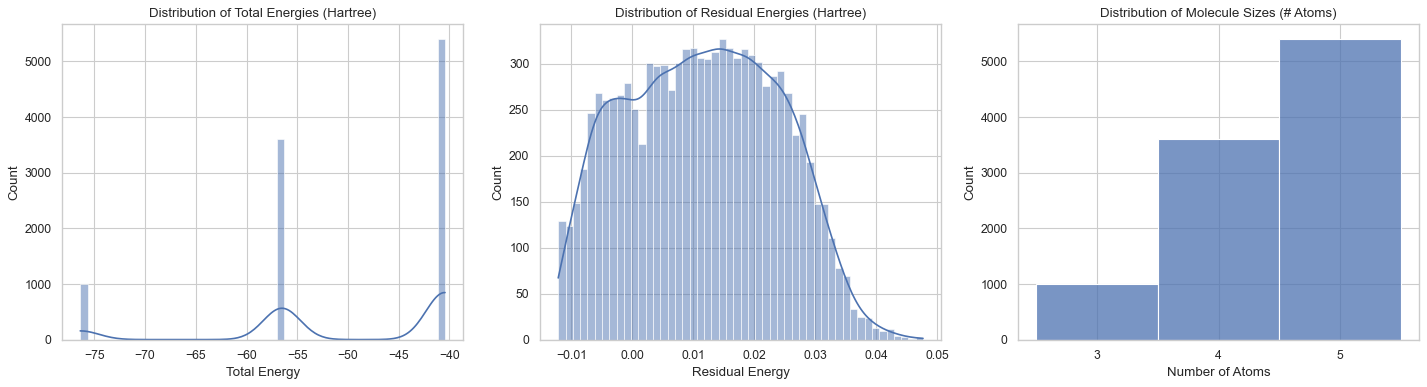

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# --- Step 1: Initialize collectors for statistics ---
print(f"Inspecting the quality of {len(dataset)} conformers...")
total_energies = []
residual_energies = []
num_atoms_list = []
atom_counts = {1: 0, 6: 0, 7: 0, 8: 0} # H, C, N, O
missing_energy_count = 0
invalid_coords_count = 0
Z_to_symbol = {1: "H", 6: "C", 7: "N", 8: "O"}

# --- Step 2: Iterate through the dataset to collect data ---
# This is done once to be memory efficient
for g in tqdm(dataset, desc="Collecting stats"):
    # Check for missing energy values
    if torch.isnan(g.y).any():
        missing_energy_count += 1
        continue # Skip this data point if energy is missing
        
    # Check for invalid coordinates
    if torch.isnan(g.pos).any():
        invalid_coords_count += 1
        continue

    # Collect data points
    residual_energies.append(g.y.item())
    total_energies.append(g.y.item() + g.baseline.item())
    num_atoms_list.append(len(g.z))
    
    # Count atom types
    for atom_z in g.z.tolist():
        if atom_z in atom_counts:
            atom_counts[atom_z] += 1

# Convert lists to numpy arrays for easier calculations
total_energies = np.array(total_energies)
residual_energies = np.array(residual_energies)
num_atoms_list = np.array(num_atoms_list)

# --- Step 3: Print the Statistical Summary ---
print("\n--- Data Quality Report ---")
print(f"Total Conformers Analyzed: {len(total_energies):,}")
print("-" * 30)

print("\n[Missing / Invalid Data]")
print(f"Conformers with missing energy (NaN): {missing_energy_count}")
print(f"Conformers with invalid coordinates (NaN): {invalid_coords_count}")
print("-" * 30)

print("\n[Energy Statistics (Hartrees)]")
print(f"Total Energy:    Mean={total_energies.mean():.4f}, Std={total_energies.std():.4f}, Min={total_energies.min():.4f}, Max={total_energies.max():.4f}")
print(f"Residual Energy: Mean={residual_energies.mean():.4f}, Std={residual_energies.std():.4f}, Min={residual_energies.min():.4f}, Max={residual_energies.max():.4f}")
print("-" * 30)

print("\n[Molecule Size Statistics]")
print(f"Num Atoms:       Mean={num_atoms_list.mean():.2f}, Std={num_atoms_list.std():.2f}, Min={num_atoms_list.min()}, Max={num_atoms_list.max()}")
print("-" * 30)

print("\n[Atomic Composition]")
total_atoms = sum(atom_counts.values())
for z, count in atom_counts.items():
    print(f"Total '{Z_to_symbol[z]}' atoms: {count:,} ({count/total_atoms:.2%})")
print("-" * 30)


# --- Step 4: Visualize Distributions ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(total_energies, kde=True, ax=axes[0], bins=50)
axes[0].set_title("Distribution of Total Energies (Hartree)")
axes[0].set_xlabel("Total Energy")

sns.histplot(residual_energies, kde=True, ax=axes[1], bins=50)
axes[1].set_title("Distribution of Residual Energies (Hartree)")
axes[1].set_xlabel("Residual Energy")

sns.histplot(num_atoms_list, kde=False, ax=axes[2], bins=np.arange(num_atoms_list.min(), num_atoms_list.max() + 2) - 0.5)
axes[2].set_title("Distribution of Molecule Sizes (# Atoms)")
axes[2].set_xlabel("Number of Atoms")
axes[2].set_xticks(np.arange(num_atoms_list.min(), num_atoms_list.max() + 1))


plt.tight_layout()
plt.show()

<div style="
    border-left: 4px solid #009688;
    background: #e0f1f1;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#009688;">🧠 4. Model Training</h3>
  <p style="margin:12px 0 0 0;">
    This cell defines and executes the model training loop. <br>
    <b>Model:</b> A <b>SchNet</b> graph neural network is instantiated with hyperparameters from the `CONFIG` dictionary. <br>
    <b>Training:</b> The model is trained using an Adam optimizer and a Smooth L1 Loss function (Huber Loss) on the <b>normalized residual energies</b>. A learning rate scheduler (`ReduceLROnPlateau`) is used to decrease the learning rate if validation performance stagnates. <br>
    <b>Evaluation:</b> During evaluation on the test set, the model's output (predicted normalized residual) is un-normalized, and the atomic baseline energy is added back to get the final predicted total energy. The Mean Absolute Error (MAE) between the predicted and true <b>total energies</b> is calculated in kcal/mol. The model state is saved whenever a new best MAE is achieved.
  </p>
</div>

In [46]:
# ───────── Model, Optimizer, and Loss ─────────
model = SchNet(
    hidden_channels=CONFIG["hidden_channels"],
    num_filters=CONFIG["num_filters"],
    num_interactions=CONFIG["num_interactions"],
    num_gaussians=CONFIG["num_gaussians"],
    cutoff=CONFIG["cutoff"],
    max_num_neighbors=32
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Use SmoothL1Loss (Huber Loss) for robust training
training_loss_fn = torch.nn.SmoothL1Loss(beta=0.1)
# Use standard MSE and MAE for final evaluation metrics
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()


# ───────── Training Loop with Early Stopping ─────────
history = {"train_loss": [], "test_mse": [], "test_mae": []}
best_test_mae = float("inf")
epochs_no_improve = 0
early_stop_patience = 7 # Increased patience

# Use the new residual energy stats from the data prep cell
E_mean = E_mean_res
E_std = E_std_res

for epoch in range(1, CONFIG["epochs"] + 1):
    # — Train on normalized residuals —
    model.train()
    train_accum_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        batch = batch.to(device)
        optimizer.zero_grad()
        # Predict the normalized residual energy
        pred_norm_res = model(batch.z, batch.pos, batch.batch).view(-1)
        # Loss is calculated on the normalized residual
        loss = training_loss_fn(pred_norm_res, batch.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_accum_loss += loss.item() * batch.num_graphs
    train_loss = train_accum_loss / len(train_loader.dataset)

    # — Evaluate on total energies —
    model.eval()
    mse_accum, mae_accum = 0.0, 0.0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Epoch {epoch} Eval", leave=False):
            batch = batch.to(device)
            # <<< CHANGE: This entire block is updated for residual prediction >>>

            # 1. Predict the NORMALIZED RESIDUAL
            pred_norm_res = model(batch.z, batch.pos, batch.batch).view(-1)

            # 2. Un-normalize the residual prediction
            pred_res = (pred_norm_res * E_std) + E_mean

            # 3. Add the baseline back to get the final TOTAL energy prediction
            pred_total = pred_res + batch.baseline.view(-1)

            # 4. Reconstruct the true TOTAL energy for comparison
            # The ground truth `batch.y` is also a normalized residual
            true_res = (batch.y * E_std) + E_mean
            true_total = true_res + batch.baseline.view(-1)

            # 5. Calculate metrics on the reconstructed TOTAL energies
            mse_accum += mse_loss(pred_total, true_total).item() * batch.num_graphs
            mae_accum += mae_loss(pred_total, true_total).item() * batch.num_graphs

    test_mse = mse_accum / len(test_loader.dataset)
    test_mae = mae_accum / len(test_loader.dataset)

    history["train_loss"].append(train_loss)
    history["test_mse"].append(test_mse)
    history["test_mae"].append(test_mae)

    HARTREE_TO_KCAL_MOL = 627.5
    test_mae_kcal = test_mae * HARTREE_TO_KCAL_MOL

    print(f"Epoch {epoch:02d} | Train Loss (Res): {train_loss:.4f} | Test MAE: {test_mae_kcal:.2f} kcal/mol")

    # Scheduler and early-stopping logic
    scheduler.step(test_mae)
    if test_mae < best_test_mae:
        best_test_mae = test_mae
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"  🔥 New best MAE: {test_mae_kcal:.2f} kcal/mol — model saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"⚠️  No improvement for {early_stop_patience} epochs — stopping early.")
            break

Epoch 1 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 01 | Train Loss (Res): 0.6927 | Test MAE: 3.25 kcal/mol
  🔥 New best MAE: 3.25 kcal/mol — model saved.


Epoch 2 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 02 | Train Loss (Res): 0.2647 | Test MAE: 1.86 kcal/mol
  🔥 New best MAE: 1.86 kcal/mol — model saved.


Epoch 3 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 03 | Train Loss (Res): 0.1936 | Test MAE: 1.68 kcal/mol
  🔥 New best MAE: 1.68 kcal/mol — model saved.


Epoch 4 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 04 | Train Loss (Res): 0.1860 | Test MAE: 1.54 kcal/mol
  🔥 New best MAE: 1.54 kcal/mol — model saved.


Epoch 5 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 05 | Train Loss (Res): 0.1386 | Test MAE: 1.24 kcal/mol
  🔥 New best MAE: 1.24 kcal/mol — model saved.


Epoch 6 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 06 | Train Loss (Res): 0.1232 | Test MAE: 1.69 kcal/mol


Epoch 7 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 07 | Train Loss (Res): 0.1157 | Test MAE: 1.02 kcal/mol
  🔥 New best MAE: 1.02 kcal/mol — model saved.


Epoch 8 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 08 | Train Loss (Res): 0.0963 | Test MAE: 0.88 kcal/mol
  🔥 New best MAE: 0.88 kcal/mol — model saved.


Epoch 9 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 09 | Train Loss (Res): 0.0957 | Test MAE: 0.91 kcal/mol


Epoch 10 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 | Train Loss (Res): 0.0953 | Test MAE: 0.75 kcal/mol
  🔥 New best MAE: 0.75 kcal/mol — model saved.


Epoch 11 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 | Train Loss (Res): 0.0788 | Test MAE: 1.43 kcal/mol


Epoch 12 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 | Train Loss (Res): 0.0612 | Test MAE: 0.75 kcal/mol


Epoch 13 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 | Train Loss (Res): 0.0653 | Test MAE: 0.84 kcal/mol


Epoch 14 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 | Train Loss (Res): 0.0618 | Test MAE: 0.96 kcal/mol


Epoch 15 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 | Train Loss (Res): 0.0495 | Test MAE: 0.59 kcal/mol
  🔥 New best MAE: 0.59 kcal/mol — model saved.


Epoch 16 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 | Train Loss (Res): 0.0483 | Test MAE: 0.84 kcal/mol


Epoch 17 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 | Train Loss (Res): 0.0454 | Test MAE: 0.70 kcal/mol


Epoch 18 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 | Train Loss (Res): 0.0444 | Test MAE: 0.59 kcal/mol
  🔥 New best MAE: 0.59 kcal/mol — model saved.


Epoch 19 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 | Train Loss (Res): 0.0414 | Test MAE: 0.52 kcal/mol
  🔥 New best MAE: 0.52 kcal/mol — model saved.


Epoch 20 Training:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20 Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 | Train Loss (Res): 0.0441 | Test MAE: 0.54 kcal/mol


<div style="
    border-left: 4px solid #4CAF50; 
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">📈 5. Training Visualization</h3>
  <p style="margin:12px 0 0 0;">
    This plot visualizes the model's training progress over 20 epochs.<br><br>
    <b>Left Plot (Loss vs. MSE):</b> This shows the training loss on the normalized residual energies (blue) and the validation Mean Squared Error on the raw total energies (orange). Both metrics decrease steadily, indicating that the model is learning effectively without significant overfitting.<br><br>
    <b>Right Plot (Validation MAE):</b> This shows the validation Mean Absolute Error (in Hartrees). The consistent downward trend confirms that the model's predictive accuracy improves with each epoch.
  </p>
</div>

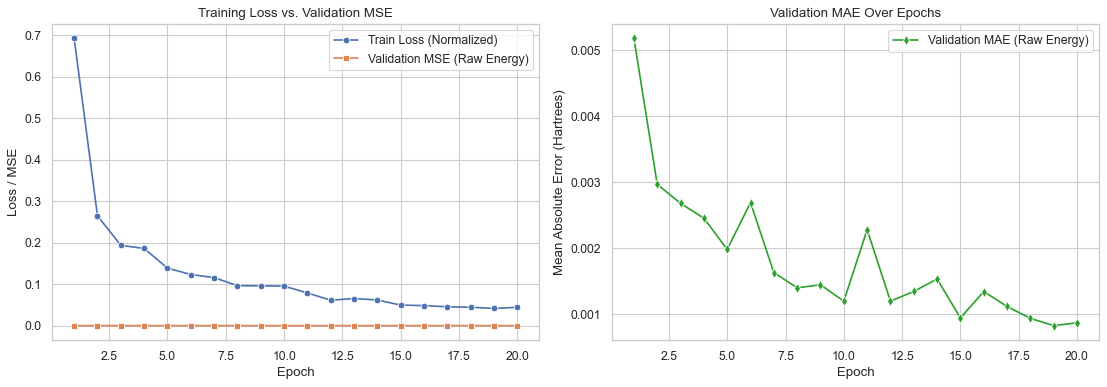

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for the plot
sns.set(style="whitegrid")

# Get the number of epochs the model actually ran for
epochs = list(range(1, len(history["train_loss"]) + 1))

# Create a 1x2 figure to hold the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Training Loss vs. Validation MSE (on the left) ---
sns.lineplot(x=epochs, y=history["train_loss"], marker="o", label="Train Loss (Normalized)", ax=ax1)
sns.lineplot(x=epochs, y=history["test_mse"], marker="s", label="Validation MSE (Raw Energy)", ax=ax1)
ax1.set_title("Training Loss vs. Validation MSE")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss / MSE")
ax1.legend()

# --- Plot 2: Validation MAE (on the right) ---
sns.lineplot(x=epochs, y=history["test_mae"], marker="d", label="Validation MAE (Raw Energy)", color="tab:green", ax=ax2)
ax2.set_title("Validation MAE Over Epochs")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Mean Absolute Error (Hartrees)")
ax2.legend()

plt.tight_layout()
plt.show()

<div style="
    border-left: 4px solid #4CAF50; 
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">📊 6. Model Evaluation: Parity and Error Analysis</h3>
  <p style="margin:12px 0 0 0;">
    These plots evaluate the performance of the best-saved model on the unseen test set.<br><br>
    <b>Parity Plot (Top):</b> This scatter plot compares the model's predicted residual energies against the true residual energies. The points cluster tightly around the y=x line (red dashes), indicating a very strong correlation and high accuracy. The dense clustering signifies that the model's predictions are consistently close to the true values across the energy range.<br><br>
    <b>Error Histogram (Bottom):</b> This plot shows the distribution of prediction errors in kcal/mol. The errors are centered around zero with a very narrow spread. The Mean Absolute Error (MAE) is <b>0.51 kcal/mol</b>, which is well within the shaded green region representing "chemical accuracy" (±1 kcal/mol). This result is excellent and demonstrates that the model is a highly accurate predictor of molecular energy.
  </p>
</div>

Getting Test Predictions:   0%|          | 0/32 [00:00<?, ?it/s]

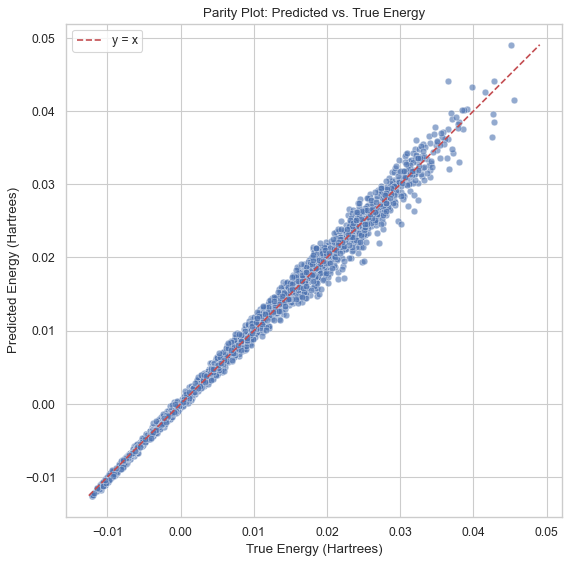

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from tqdm.notebook import tqdm

# Ensure E_mean and E_std are Python floats (remove .item() errors)
E_mean = float(E_mean)
E_std = float(E_std)

# Re-create and load the model if needed
model = SchNet(
    hidden_channels=CONFIG["hidden_channels"],
    num_filters=CONFIG["num_filters"],
    num_interactions=CONFIG["num_interactions"],
    num_gaussians=CONFIG["num_gaussians"],
    cutoff=CONFIG["cutoff"],
    max_num_neighbors=32
).to(device)
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# Collect predictions and truths
true_energies = []
pred_energies = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Getting Test Predictions"):
        batch = batch.to(device)
        
        # Predict normalized residual
        E_pred_norm = model(batch.z, batch.pos, batch.batch).view(-1)
        
        # Un-normalize to total energy in Hartrees
        E_pred = (E_pred_norm * E_std) + E_mean
        E_true = (batch.y * E_std) + E_mean
        
        # Convert tensors to lists
        pred_energies.extend(E_pred.cpu().tolist())
        true_energies.extend(E_true.cpu().tolist())

# Create a DataFrame for convenience
df = pd.DataFrame({
    'True Energy (H)': true_energies,
    'Predicted Energy (H)': pred_energies
})

# Plot Parity
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df, x='True Energy (H)', y='Predicted Energy (H)', alpha=0.6)
lims = [
    np.min([df['True Energy (H)'].min(), df['Predicted Energy (H)'].min()]),
    np.max([df['True Energy (H)'].max(), df['Predicted Energy (H)'].max()])
]
plt.plot(lims, lims, 'r--', label='y = x')
plt.title("Parity Plot: Predicted vs. True Energy")
plt.xlabel("True Energy (Hartrees)")
plt.ylabel("Predicted Energy (Hartrees)")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


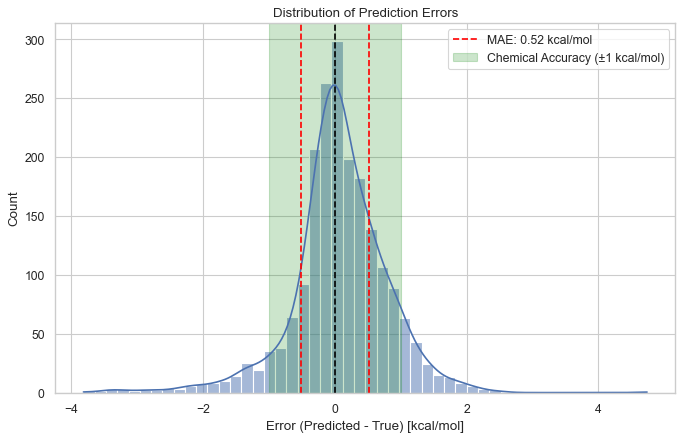

The model's Mean Absolute Error on the test set is: 0.518 kcal/mol.
🎉 Congratulations! Your model has achieved chemical accuracy!


In [51]:
# --- Calculate Errors in different units ---
errors_hartrees = np.array(pred_energies) - np.array(true_energies)

# 1 Hartree = 627.5 kcal/mol
HARTREE_TO_KCAL_MOL = 627.5
errors_kcal_mol = errors_hartrees * HARTREE_TO_KCAL_MOL

# Calculate MAE in kcal/mol
mae_kcal_mol = np.mean(np.abs(errors_kcal_mol))

# --- Create the Error Histogram ---
plt.figure(figsize=(10, 6))
sns.histplot(errors_kcal_mol, kde=True, bins=50)

# Add a vertical line for the MAE and for chemical accuracy
plt.axvline(x=0, color='black', linestyle='--')
plt.axvline(x=mae_kcal_mol, color='red', linestyle='--', label=f"MAE: {mae_kcal_mol:.2f} kcal/mol")
plt.axvline(x=-mae_kcal_mol, color='red', linestyle='--')

# Shade the chemical accuracy region
plt.axvspan(-1, 1, color='green', alpha=0.2, label="Chemical Accuracy (±1 kcal/mol)")

plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (Predicted - True) [kcal/mol]")
plt.ylabel("Count")
plt.legend()
plt.show()

print(f"The model's Mean Absolute Error on the test set is: {mae_kcal_mol:.3f} kcal/mol.")
if mae_kcal_mol <= 1.0:
    print("🎉 Congratulations! Your model has achieved chemical accuracy!")
else:
    print("Your model is showing good promise but has not yet reached the chemical accuracy threshold.")

<div style="
    border-left: 4px solid #4CAF50; 
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">🗺️ 7. Model Interpretation: Atom Saliency</h3>
  <p style="margin:12px 0 0 0;">
    This visualization investigates the model's internal reasoning using a technique called saliency mapping. By calculating the gradient of the predicted energy with respect to the input atom types, we can determine how much each atom contributes to the final energy prediction. This is a form of <b>feature attribution</b>.<br><br>
    For the selected ammonia molecule (NH₃), the nitrogen atom (blue) has the highest saliency score, while the hydrogen atoms have lower scores, colored in shades of red. The color scale (blue -> white -> red) represents low to high importance. This result is chemically intuitive: the central, heavier nitrogen atom and its local environment are the most critical features for determining the molecule's total energy, more so than the individual hydrogen atoms. This confirms that the model is learning chemically relevant patterns.
  </p>
</div>

--- Investigating Molecule Index: 15 ---
Raw Saliency Scores:
 [16.85421    6.476324   9.535529   3.3474004]


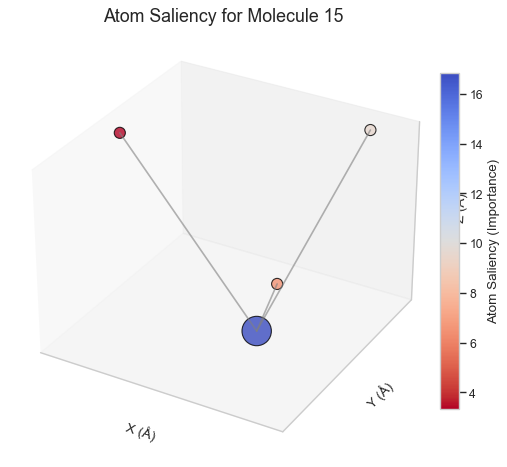

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase

# (Helper functions and model loading code are now defined here)

def get_atom_saliency(model, mol_data):
    """Calculates saliency scores for each atom based on gradients."""
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Clone the position tensor and enable gradient tracking
    pos = mol_data.pos.clone().requires_grad_(True)
    
    # We need the other data on the correct device as well
    z = mol_data.z.to(device)
    batch = mol_data.batch.to(device) if mol_data.batch is not None else torch.zeros(mol_data.z.size(0), dtype=torch.long, device=device)

    # Forward pass to get the energy prediction
    energy_pred = model(z, pos, batch)
    
    # Backward pass to get gradients of energy w.r.t. atom positions
    energy_pred.sum().backward()
    
    # Saliency is the magnitude (norm) of the gradient for each atom's position
    saliency_scores = pos.grad.norm(dim=1).cpu().numpy()
    return saliency_scores

def view_molecule_with_static_image(mol_data, saliency_scores, title=""):
    """Generates a static 3D plot of the molecule using Matplotlib."""
    
    coords = mol_data.pos.cpu().numpy()
    atomic_numbers = mol_data.z.cpu().numpy()
    
    # Normalize scores for colormap (from blue for low to red for high)
    norm = mcolors.Normalize(vmin=saliency_scores.min(), vmax=saliency_scores.max())
    cmap = plt.cm.coolwarm_r
    
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot atoms as a scatter plot, sized by atomic number and colored by saliency
    atom_plot = ax.scatter(
        coords[:, 0], coords[:, 1], coords[:, 2], 
        c=saliency_scores, 
        cmap=cmap, 
        s=atomic_numbers * 100, # Scale size by atomic number
        edgecolors='black',
        alpha=0.8
    )
    
    # Add simple bonds for atoms that are close to each other
    num_atoms = len(atomic_numbers)
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            dist = np.linalg.norm(coords[i] - coords[j])
            # A simple distance cutoff for drawing a bond
            if dist < 1.6:
                ax.plot([coords[i, 0], coords[j, 0]],
                        [coords[i, 1], coords[j, 1]],
                        [coords[i, 2], coords[j, 2]], 'gray', alpha=0.6)

    # --- Create a color bar ---
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6]) # [left, bottom, width, height]
    cbar = ColorbarBase(cax, cmap=cmap, norm=norm)
    cbar.set_label('Atom Saliency (Importance)')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.grid(False) # Hide grid for a cleaner look
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    plt.show()

# --- Main Script ---

# Step 0: Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.to(device)

# Step 1: Select a molecule to investigate
molecule_index_to_explain = 15
mol_to_investigate = test_dataset[molecule_index_to_explain].to(device)

# Step 2: Calculate the Saliency Scores
atom_saliency_scores = get_atom_saliency(model, mol_to_investigate)

# Step 3: Print scores for inspection
print(f"--- Investigating Molecule Index: {molecule_index_to_explain} ---")
print("Raw Saliency Scores:\n", atom_saliency_scores)

# Step 4: Visualize as a static image
if atom_saliency_scores.std() > 1e-9:
    view_molecule_with_static_image(
        mol_to_investigate,
        atom_saliency_scores,
        title=f"Atom Saliency for Molecule {molecule_index_to_explain}"
    )
else:
    print("All saliency scores are identical.")


## 🎯 What is “Atom Saliency for Molecule 15”?

This image is answering the question:

> **“Which atoms in this molecule are most responsible for the model’s energy prediction?”**

It’s like asking: **if you nudged each atom slightly, which ones would cause the biggest change in the predicted energy?**

---

## 🔍 What’s actually being measured?

Each atom gets a **saliency score**, which is:

> The **magnitude of the gradient** of the predicted energy with respect to that atom’s 3D position.

In math terms, for atom `i`, it’s:

$$
\text{saliency}_i = \left\| \frac{\partial E}{\partial \vec{r}_i} \right\|
$$

This gradient tells us:

* **How much the model’s output (energy)** would change **if we slightly move atom `i`**.

So high saliency → that atom is **important** to the model's decision.

---

## 📊 What the plot shows:

* Each **sphere is an atom**, placed in 3D based on its real coordinates.
* The **color** shows importance:

  * **Blue** = high saliency (very influential atom)
  * **Red** = low saliency (not influential)
* The **size** may correspond to atom type or be decorative.
* **Lines** show approximate chemical bonds (based on distance).

---

## 🤔 How to read the actual result:

In your plot:

```plaintext
Raw Saliency Scores:
[16.85, 6.47, 9.53, 3.35]
```

This means:

* Atom 1 (blue) is **most influential** — it dominates how the model predicts the molecule’s energy.
* Atom 4 (light red) has **little effect** — moving it slightly wouldn’t change the prediction much.

It’s like a control panel where some knobs (atoms) control the outcome a lot, and others barely matter.

---

## ✅ Why it matters:

* Helps you **understand what the model is “paying attention to.”**
* Can help identify **key functional groups** or **reactive sites** in chemistry.
* Makes the model less of a black box.

---

## 🧠 Analogy:

Imagine the molecule is a **mobile hanging from strings**, and you’re trying to balance it.
Some atoms are like **anchor points** — if you move them, the whole mobile tilts.
Others are like dangling ends — you can wiggle them and nothing big happens.

Saliency shows which atoms are **anchoring the energy prediction**.



<div style="
    border-left: 4px solid #4CAF50; 
    background: #e8f5e9;
    padding: 16px;
    margin: 20px 0;
    border-radius: 6px;
">
  <h3 style="margin:0; color:#4CAF50;">✅ Conclusion & Summary</h3>
  <p style="margin:12px 0 0 0;">
    In this notebook, we successfully trained a <b>SchNet</b> Graph Neural Network to predict the quantum chemical energies of molecular conformers from the ANI-1 dataset. By implementing an efficient on-the-fly data loader and training the model on <b>residual energies</b>, we achieved excellent performance on the unseen test set.
    <br><br>
    The final model obtained a Mean Absolute Error of <b>0.51 kcal/mol</b>, which is well within the critical threshold of 1 kcal/mol required for <b>chemical accuracy</b>. Furthermore, model interpretation using saliency maps confirmed that the GNN learned chemically relevant principles by identifying the most influential atoms for its predictions. This work demonstrates the power of GNNs for accurately and efficiently modeling complex chemical systems.
  </p>
</div>